In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df= pd.read_csv("../data/cleaned_city_day.csv")

In [3]:
df.head()

,City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI
0,Ahmedabad,2015-01-01,78.229314,115.195651,0.92,18.22,17.15,23.371912,0.92,27.64,133.36,0.00,0.02,0.00,399.051742
1,Ahmedabad,2015-01-02,78.229314,115.195651,0.97,15.69,16.46,23.371912,0.97,24.55,34.06,3.68,5.50,3.77,399.051742
2,Ahmedabad,2015-01-03,78.229314,115.195651,17.40,19.30,29.70,23.371912,17.40,29.07,30.70,6.80,16.40,2.25,399.051742
3,Ahmedabad,2015-01-04,78.229314,115.195651,1.70,18.48,17.97,23.371912,1.70,18.59,36.08,4.43,10.14,1.00,399.051742
4,Ahmedabad,2015-01-05,78.229314,115.195651,22.10,21.42,37.76,23.371912,22.10,39.33,39.31,7.01,18.89,2.78,399.051742


In [4]:
df.shape

(29531, 15)

### Feature Engineering to Boost Model Accuracy

To improve my model’s accuracy, I engineered features that capture time-based patterns and recent trends from the air quality dataset.

---

#### 1. Time-Based Features

- **Month:** Extracted the month number (1–12) from the `Date` column to help the model recognize seasonal patterns (e.g., winter smog, pre-monsoon dust).
- **Year:** Added the year to capture long-term, year-over-year changes in air quality.

---

#### 2. Lag Features

- **Previous Day’s AQI:** Created a new column containing the AQI value from the previous day.
- **Previous Day’s Pollutants:** Added lag features for key pollutants, especially PM2.5, to track short-term fluctuations.

---

#### 3. Rolling Averages (Moving Averages)

- **7-Day Rolling AQI:** Computed the average AQI over the last 7 days to smooth out daily noise.
- **7-Day Rolling PM2.5:** Calculated the 7-day average for PM2.5 to indicate recent trends in air quality.

---

By adding time-based context, historical lags, and trend-based averages, the model receives much richer information than just raw daily pollutant readings—significantly improving its predictive power.

In [5]:
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by=['City', 'Date'], inplace=True)

# --- 1. I'm creating the Time-Based Features ---
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year

In [6]:
# --- 2. I'm creating the Lag Features ---
# I'll group by city to make sure the lag is calculated correctly for each location.
df['AQI_lag_1'] = df.groupby('City')['AQI'].shift(1)

In [7]:
# --- 3. I'm creating the Rolling Average Features ---
# This captures the recent trend over the last week.
window_size = 7
df['AQI_rolling_7'] = df.groupby('City')['AQI'].transform(
    lambda x: x.rolling(window=window_size, min_periods=1).mean()
)
df['PM2.5_rolling_7'] = df.groupby('City')['PM2.5'].transform(
    lambda x: x.rolling(window=window_size, min_periods=1).mean()
)

In [8]:
df.head()

,City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,Month,Year,AQI_lag_1,AQI_rolling_7,PM2.5_rolling_7
0,Ahmedabad,2015-01-01,78.229314,115.195651,0.92,18.22,17.15,23.371912,0.92,27.64,133.36,0.00,0.02,0.00,399.051742,1,2015,NaN,399.051742,78.229314
1,Ahmedabad,2015-01-02,78.229314,115.195651,0.97,15.69,16.46,23.371912,0.97,24.55,34.06,3.68,5.50,3.77,399.051742,1,2015,399.051742,399.051742,78.229314
2,Ahmedabad,2015-01-03,78.229314,115.195651,17.40,19.30,29.70,23.371912,17.40,29.07,30.70,6.80,16.40,2.25,399.051742,1,2015,399.051742,399.051742,78.229314
3,Ahmedabad,2015-01-04,78.229314,115.195651,1.70,18.48,17.97,23.371912,1.70,18.59,36.08,4.43,10.14,1.00,399.051742,1,2015,399.051742,399.051742,78.229314
4,Ahmedabad,2015-01-05,78.229314,115.195651,22.10,21.42,37.76,23.371912,22.10,39.33,39.31,7.01,18.89,2.78,399.051742,1,2015,399.051742,399.051742,78.229314


In [9]:
# --- 4. I'll handle the new missing values ---
# The shift() and rolling() functions create NaNs at the start of each city's data.
# I'll drop these rows as they can't be used for training.
df.dropna(inplace=True)

In [10]:
df.head()

,City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,Month,Year,AQI_lag_1,AQI_rolling_7,PM2.5_rolling_7
1,Ahmedabad,2015-01-02,78.229314,115.195651,0.97,15.69,16.46,23.371912,0.97,24.55,34.06,3.68,5.50,3.77,399.051742,1,2015,399.051742,399.051742,78.229314
2,Ahmedabad,2015-01-03,78.229314,115.195651,17.40,19.30,29.70,23.371912,17.40,29.07,30.70,6.80,16.40,2.25,399.051742,1,2015,399.051742,399.051742,78.229314
3,Ahmedabad,2015-01-04,78.229314,115.195651,1.70,18.48,17.97,23.371912,1.70,18.59,36.08,4.43,10.14,1.00,399.051742,1,2015,399.051742,399.051742,78.229314
4,Ahmedabad,2015-01-05,78.229314,115.195651,22.10,21.42,37.76,23.371912,22.10,39.33,39.31,7.01,18.89,2.78,399.051742,1,2015,399.051742,399.051742,78.229314
5,Ahmedabad,2015-01-06,78.229314,115.195651,45.41,38.48,81.50,23.371912,45.41,45.76,46.51,5.42,10.83,1.93,399.051742,1,2015,399.051742,399.051742,78.229314


In [11]:
df.isnull().sum()

City               0
Date               0
PM2.5              0
PM10               0
NO                 0
NO2                0
NOx                0
NH3                0
CO                 0
SO2                0
O3                 0
Benzene            0
Toluene            0
Xylene             0
AQI                0
Month              0
Year               0
AQI_lag_1          0
AQI_rolling_7      0
PM2.5_rolling_7    0
dtype: int64

In [12]:
df.shape

(29505, 20)

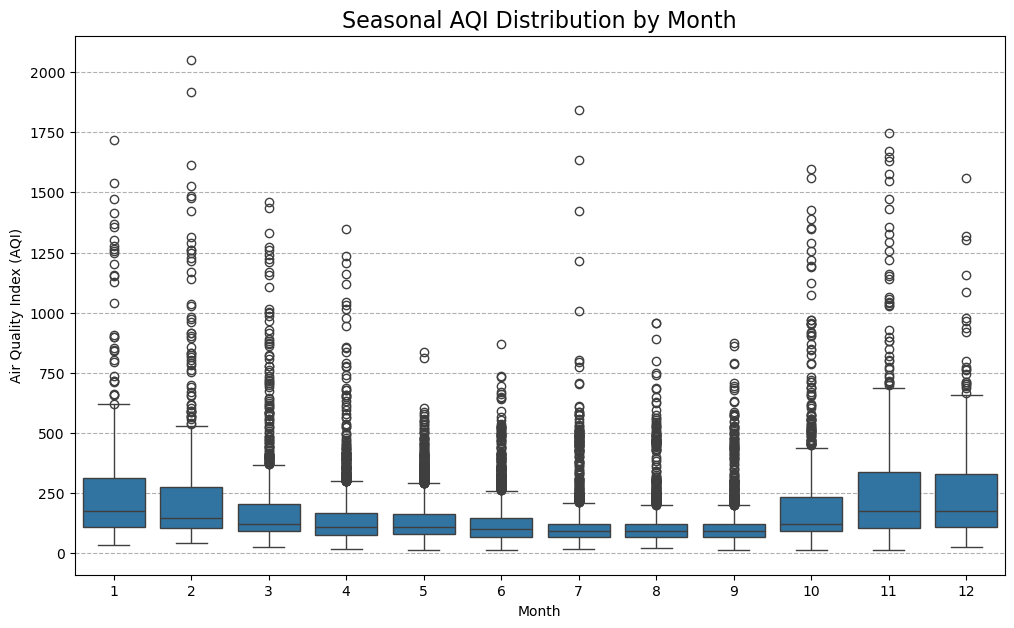

<Figure size 640x480 with 0 Axes>

In [15]:
# I'll create a box plot to see the distribution of AQI for each month.
plt.figure(figsize=(12, 7))
sns.boxplot(x='Month', y='AQI', data=df)
plt.title('Seasonal AQI Distribution by Month', fontsize=16)
plt.xlabel('Month')
plt.ylabel('Air Quality Index (AQI)')
plt.grid(axis='y', linestyle='--')
plt.show()
plt.savefig("../images/seasonal_aqi_distribution.png", dpi=300)

WE see higher AQI values during the winter months (like November, December, January) and lower values during the monsoon season, confirming a strong seasonal pattern.

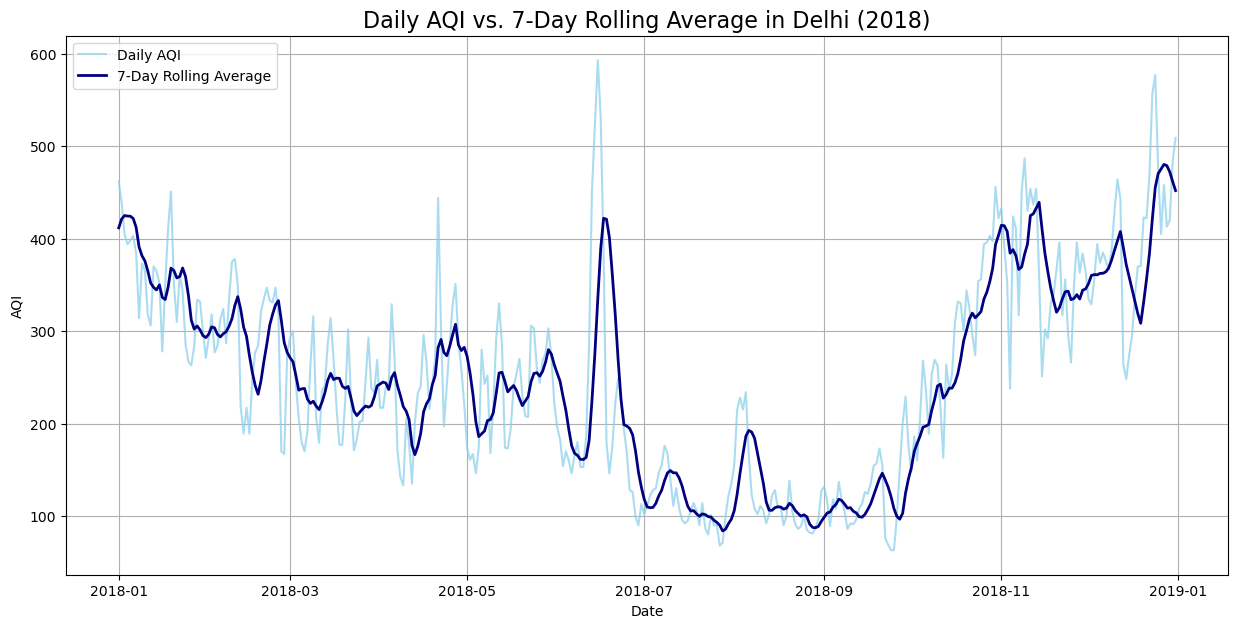

<Figure size 640x480 with 0 Axes>

In [14]:
# I'll filter for a single city and a specific year to make the plot readable.
df_plot = df[(df['City'] == 'Delhi')
                      & (df['Year'] == 2018)]

plt.figure(figsize=(15, 7))
# I'll plot the original daily AQI in a lighter color.
plt.plot(df_plot['Date'], df_plot['AQI'],
         label='Daily AQI', color='skyblue', alpha=0.7)
# I'll plot the 7-day rolling average in a darker, solid line.
plt.plot(df_plot['Date'], df_plot['AQI_rolling_7'],
         label='7-Day Rolling Average', color='navy', linewidth=2)

plt.title('Daily AQI vs. 7-Day Rolling Average in Delhi (2018)', fontsize=16)
plt.xlabel('Date')
plt.ylabel('AQI')
plt.legend()
plt.grid(True)
plt.show()
plt.savefig("../images/daily_aqi_vs_rolling_avg.png", dpi=300)

A jagged light blue line (Daily AQI) with a smooth, dark blue line (Rolling Average) running through it, showing the smoothed trend.

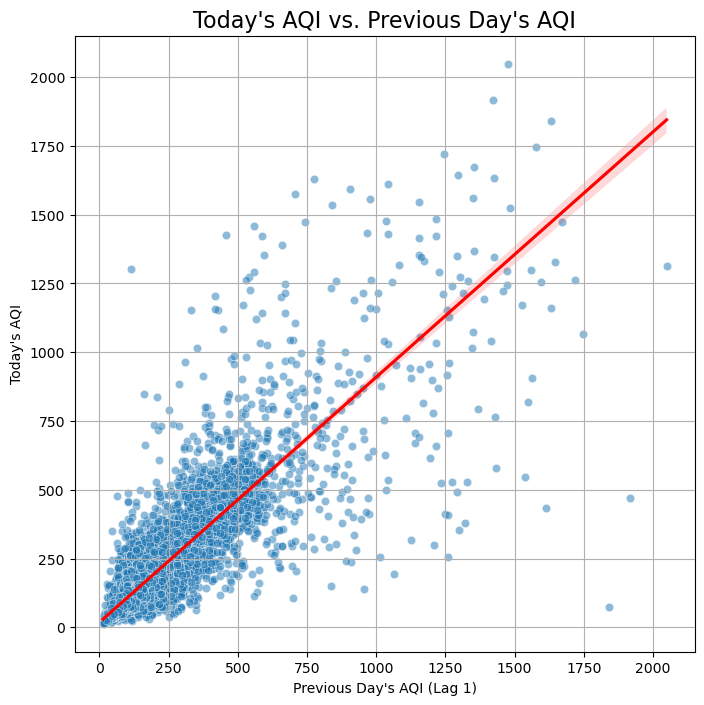

<Figure size 640x480 with 0 Axes>

In [16]:
# I'll create a scatter plot to see the correlation.
plt.figure(figsize=(8, 8))
sns.scatterplot(x='AQI_lag_1', y='AQI', data=df, alpha=0.5)
# I'll add a regression line to make the trend clearer.
sns.regplot(x='AQI_lag_1', y='AQI', data=df,
            scatter=False, color='red')

plt.title("Today's AQI vs. Previous Day's AQI", fontsize=16)
plt.xlabel("Previous Day's AQI (Lag 1)")
plt.ylabel("Today's AQI")
plt.grid(True)
plt.show()
plt.savefig("../images/lag_feature_correlation.png", dpi=300)

The points should form a tight, straight line going from the bottom-left to the top-right, indicating a strong positive correlation.

In [19]:
df.to_csv("../data/EDAed_city_day.csv", index=False)